<a href="https://colab.research.google.com/github/Sannevastaveren/Donders_internship/blob/main/Stage_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Modules

In [ ]:
#@title <font size="5">← ឵឵<i>Upgrade FFmpeg to v4.2.2</font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

Installation finished.


In [ ]:
#(this will take a few minutes to install all the dependences!)
!pip install scenedetect
!pip install moviepy
!pip install deeplabcut

# Use TensorFlow 1.x:
%tensorflow_version 1.x

## Open Ephys code

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug  3 15:18:38 2014
@author: Dan Denman and Josh Siegle
Loads .continuous, .events, and .spikes files saved from the Open Ephys GUI
Usage:
    import OpenEphys
    data = OpenEphys.load(pathToFile) # returns a dict with data, timestamps, etc.
"""

import os
import numpy as np
import scipy.signal
import scipy.io
import time
import struct
from copy import deepcopy

# constants
NUM_HEADER_BYTES = 1024
SAMPLES_PER_RECORD = 1024
BYTES_PER_SAMPLE = 2
RECORD_SIZE = 4 + 8 + SAMPLES_PER_RECORD * BYTES_PER_SAMPLE + 10 # size of each continuous record in bytes
RECORD_MARKER = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 255])

# constants for pre-allocating matrices:
MAX_NUMBER_OF_SPIKES = int(1e6)
MAX_NUMBER_OF_RECORDS = int(1e6)
MAX_NUMBER_OF_EVENTS = int(1e6)

def load(filepath, dtype = float):

    # redirects to code for individual file types
    if 'continuous' in filepath:
        data = loadContinuous(filepath, dtype)
    elif 'spikes' in filepath:
        data = loadSpikes(filepath)
    elif 'events' in filepath:
        data = loadEvents(filepath)
    else:
        raise Exception("Not a recognized file type. Please input a .continuous, .spikes, or .events file")

    return data

def loadFolder(folderpath, dtype = float, **kwargs):

    # load all continuous files in a folder

    data = { }

    # load all continuous files in a folder
    if 'channels' in kwargs.keys():
        filelist = ['100_CH'+x+'.continuous' for x in map(str,kwargs['channels'])]
    else:
        filelist = os.listdir(folderpath)

    t0 = time.time()
    numFiles = 0

    for i, f in enumerate(filelist):
        if '.continuous' in f:
            data[f.replace('.continuous','')] = loadContinuous(os.path.join(folderpath, f), dtype = dtype)
            numFiles += 1

    print(''.join(('Avg. Load Time: ', str((time.time() - t0)/numFiles),' sec')))
    print(''.join(('Total Load Time: ', str((time.time() - t0)),' sec')))

    return data

def loadFolderToArray(folderpath, channels = 'all', chprefix = 'CH',
                      dtype = float, session = '0', source = '100'):
    '''Load continuous files in specified folder to a single numpy array. By default all
    CH continous files are loaded in numerical order, ordering can be specified with
    optional channels argument which should be a list of channel numbers.'''

    if channels == 'all':
        channels = _get_sorted_channels(folderpath, chprefix, session, source)

    if session == '0':
        filelist = [source + '_'+chprefix + x + '.continuous' for x in map(str,channels)]
    else:
        filelist = [source + '_'+chprefix + x + '_' + session + '.continuous' for x in map(str,channels)]

    t0 = time.time()
    numFiles = 1

    channel_1_data = loadContinuous(os.path.join(folderpath, filelist[0]), dtype)['data']

    n_samples  = len(channel_1_data)
    n_channels = len(filelist)

    data_array = np.zeros([n_samples, n_channels], dtype)
    data_array[:,0] = channel_1_data

    for i, f in enumerate(filelist[1:]):
            data_array[:, i + 1] = loadContinuous(os.path.join(folderpath, f), dtype)['data']
            numFiles += 1

    print(''.join(('Avg. Load Time: ', str((time.time() - t0)/numFiles),' sec')))
    print(''.join(('Total Load Time: ', str((time.time() - t0)),' sec')))

    return data_array

def loadContinuous(filepath, dtype = float):

    assert dtype in (float, np.int16), \
      'Invalid data type specified for loadContinous, valid types are float and np.int16'

    print("Loading continuous data...")

    ch = { }

    #read in the data
    f = open(filepath,'rb')

    fileLength = os.fstat(f.fileno()).st_size

    # calculate number of samples
    recordBytes = fileLength - NUM_HEADER_BYTES
    if  recordBytes % RECORD_SIZE != 0:
        raise Exception("File size is not consistent with a continuous file: may be corrupt")
    nrec = recordBytes // RECORD_SIZE
    nsamp = nrec * SAMPLES_PER_RECORD
    # pre-allocate samples
    samples = np.zeros(nsamp, dtype)
    timestamps = np.zeros(nrec)
    recordingNumbers = np.zeros(nrec)
    indices = np.arange(0, nsamp + 1, SAMPLES_PER_RECORD, np.dtype(np.int64))

    header = readHeader(f)

    recIndices = np.arange(0, nrec)

    for recordNumber in recIndices:

        timestamps[recordNumber] = np.fromfile(f,np.dtype('<i8'),1) # little-endian 64-bit signed integer
        N = np.fromfile(f,np.dtype('<u2'),1)[0] # little-endian 16-bit unsigned integer

        #print index

        if N != SAMPLES_PER_RECORD:
            raise Exception('Found corrupted record in block ' + str(recordNumber))

        recordingNumbers[recordNumber] = (np.fromfile(f,np.dtype('>u2'),1)) # big-endian 16-bit unsigned integer

        if dtype == float: # Convert data to float array and convert bits to voltage.
            data = np.fromfile(f,np.dtype('>i2'),N) * float(header['bitVolts']) # big-endian 16-bit signed integer, multiplied by bitVolts
        else:  # Keep data in signed 16 bit integer format.
            data = np.fromfile(f,np.dtype('>i2'),N)  # big-endian 16-bit signed integer
        samples[indices[recordNumber]:indices[recordNumber+1]] = data

        marker = f.read(10) # dump

    #print recordNumber
    #print index

    ch['header'] = header
    ch['timestamps'] = timestamps
    ch['data'] = samples  # OR use downsample(samples,1), to save space
    ch['recordingNumber'] = recordingNumbers
    f.close()
    return ch

def loadSpikes(filepath):

    '''
    Loads spike waveforms and timestamps from filepath (should be .spikes file)
    '''

    data = { }

    print('loading spikes...')

    f = open(filepath, 'rb')
    header = readHeader(f)

    if float(header[' version']) < 0.4:
        raise Exception('Loader is only compatible with .spikes files with version 0.4 or higher')

    data['header'] = header
    numChannels = int(header['num_channels'])
    numSamples = 40 # **NOT CURRENTLY WRITTEN TO HEADER**

    spikes = np.zeros((MAX_NUMBER_OF_SPIKES, numSamples, numChannels))
    timestamps = np.zeros(MAX_NUMBER_OF_SPIKES)
    source = np.zeros(MAX_NUMBER_OF_SPIKES)
    gain = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    thresh = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    sortedId = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    recNum = np.zeros(MAX_NUMBER_OF_SPIKES)

    currentSpike = 0

    while f.tell() < os.fstat(f.fileno()).st_size:
        eventType = np.fromfile(f, np.dtype('<u1'),1) #always equal to 4, discard
        timestamps[currentSpike] = np.fromfile(f, np.dtype('<i8'), 1)
        software_timestamp = np.fromfile(f, np.dtype('<i8'), 1)
        source[currentSpike] = np.fromfile(f, np.dtype('<u2'), 1)
        numChannels = np.fromfile(f, np.dtype('<u2'), 1)[0]
        numSamples = np.fromfile(f, np.dtype('<u2'), 1)[0]
        sortedId[currentSpike] = np.fromfile(f, np.dtype('<u2'),1)
        electrodeId = np.fromfile(f, np.dtype('<u2'),1)
        channel = np.fromfile(f, np.dtype('<u2'),1)
        color = np.fromfile(f, np.dtype('<u1'), 3)
        pcProj = np.fromfile(f, np.float32, 2)
        sampleFreq = np.fromfile(f, np.dtype('<u2'),1)

        waveforms = np.fromfile(f, np.dtype('<u2'), numChannels*numSamples)
        gain[currentSpike,:] = np.fromfile(f, np.float32, numChannels)
        thresh[currentSpike,:] = np.fromfile(f, np.dtype('<u2'), numChannels)
        recNum[currentSpike] = np.fromfile(f, np.dtype('<u2'), 1)

        waveforms_reshaped = np.reshape(waveforms, (numChannels, numSamples))
        waveforms_reshaped = waveforms_reshaped.astype(float)
        waveforms_uv = waveforms_reshaped

        for ch in range(numChannels):
            waveforms_uv[ch, :] -= 32768
            waveforms_uv[ch, :] /= gain[currentSpike, ch]*1000

        spikes[currentSpike] = waveforms_uv.T

        currentSpike += 1

    data['spikes'] = spikes[:currentSpike,:,:]
    data['timestamps'] = timestamps[:currentSpike]
    data['source'] = source[:currentSpike]
    data['gain'] = gain[:currentSpike,:]
    data['thresh'] = thresh[:currentSpike,:]
    data['recordingNumber'] = recNum[:currentSpike]
    data['sortedId'] = sortedId[:currentSpike]

    return data


def loadEvents(filepath):

    data = { }

    print('loading events...')

    f = open(filepath,'rb')
    header = readHeader(f)

    if float(header[' version']) < 0.4:
        raise Exception('Loader is only compatible with .events files with version 0.4 or higher')

    data['header'] = header

    index = -1

    channel = np.zeros(MAX_NUMBER_OF_EVENTS)
    timestamps = np.zeros(MAX_NUMBER_OF_EVENTS)
    sampleNum = np.zeros(MAX_NUMBER_OF_EVENTS)
    nodeId = np.zeros(MAX_NUMBER_OF_EVENTS)
    eventType = np.zeros(MAX_NUMBER_OF_EVENTS)
    eventId = np.zeros(MAX_NUMBER_OF_EVENTS)
    recordingNumber = np.zeros(MAX_NUMBER_OF_EVENTS)

    while f.tell() < os.fstat(f.fileno()).st_size:

        index += 1

        timestamps[index] = np.fromfile(f, np.dtype('<i8'), 1)
        sampleNum[index] = np.fromfile(f, np.dtype('<i2'), 1)
        eventType[index] = np.fromfile(f, np.dtype('<u1'), 1)
        nodeId[index] = np.fromfile(f, np.dtype('<u1'), 1)
        eventId[index] = np.fromfile(f, np.dtype('<u1'), 1)
        channel[index] = np.fromfile(f, np.dtype('<u1'), 1)
        recordingNumber[index] = np.fromfile(f, np.dtype('<u2'), 1)

    data['channel'] = channel[:index]
    data['timestamps'] = timestamps[:index]
    data['eventType'] = eventType[:index]
    data['nodeId'] = nodeId[:index]
    data['eventId'] = eventId[:index]
    data['recordingNumber'] = recordingNumber[:index]
    data['sampleNum'] = sampleNum[:index]

    return data

def readHeader(f):
    header = { }
    h = f.read(1024).decode().replace('\n','').replace('header.','')
    for i,item in enumerate(h.split(';')):
        if '=' in item:
            header[item.split(' = ')[0]] = item.split(' = ')[1]
    return header

def downsample(trace,down):
    downsampled = scipy.signal.resample(trace,np.shape(trace)[0]/down)
    return downsampled

def pack(folderpath,source='100',**kwargs):
#convert single channel open ephys channels to a .dat file for compatibility with the KlustaSuite, Neuroscope and Klusters
#should not be necessary for versions of open ephys which write data into HDF5 format.
#loads .continuous files in the specified folder and saves a .DAT in that folder
#optional arguments:
#   source: string name of the source that openephys uses as the prefix. is usually 100, if the headstage is the first source added, but can specify something different
#
#   data: pre-loaded data to be packed into a .DAT
#   dref: int specifying a channel # to use as a digital reference. is subtracted from all channels.
#   order: the order in which the .continuos files are packed into the .DAT. should be a list of .continious channel numbers. length must equal total channels.
#   suffix: appended to .DAT filename, which is openephys.DAT if no suffix provided.

    #load the openephys data into memory
    if 'data' not in kwargs.keys():
        if 'channels' not in kwargs.keys():
            data = loadFolder(folderpath, dtype = np.int16)
        else:
            data = loadFolder(folderpath, dtype = np.int16, channels=kwargs['channels'])
    else:
        data = kwargs['data']
    #if specified, do the digital referencing
    if 'dref' in kwargs.keys():
        ref =load(os.path.join(folderpath,''.join((source,'_CH',str(kwargs['dref']),'.continuous'))))
        for i,channel in enumerate(data.keys()):
            data[channel]['data'] = data[channel]['data'] - ref['data']
    #specify the order the channels are written in
    if 'order' in kwargs.keys():
        order = kwargs['order']
    else:
        order = list(data)
    #add a suffix, if one was specified
    if 'suffix' in kwargs.keys():
        suffix=kwargs['suffix']
    else:
        suffix=''

    #make a file to write the data back out into .dat format
    outpath = os.path.join(folderpath,''.join(('openephys',suffix,'.dat')))
    out = open(outpath,'wb')

    #go through the data and write it out in the .dat format
    #.dat format specified here: http://neuroscope.sourceforge.net/UserManual/data-files.html
    channelOrder = []
    print(''.join(('...saving .dat to ',outpath,'...')))
    random_datakey = next(iter(data))
    bar = ProgressBar(len(data[random_datakey]['data']))
    for i in range(len(data[random_datakey]['data'])):
        for j in range(len(order)):
            if source in random_datakey:
                ch = data[order[j]]['data']
            else:
                ch = data[''.join(('CH',str(order[j]).replace('CH','')))]['data']
            out.write(struct.pack('h',ch[i]))#signed 16-bit integer
            #figure out which order this thing packed the channels in. only do this once.
            if i == 0:
                channelOrder.append(order[j])
        #update how mucb we have list
        if i%(len(data[random_datakey]['data'])/100)==0:
            bar.animate(i)
    out.close()
    print(''.join(('order: ',str(channelOrder))))
    print(''.join(('.dat saved to ',outpath)))

#**********************************************************
# progress bar class used to show progress of pack()
    #stolen from some post on stack overflow
import sys
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self,)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)
#*************************************************************

def pack_2(folderpath, filename = '', channels = 'all', chprefix = 'CH',
           dref = None, session = '0', source = '100'):

    '''Alternative version of pack which uses numpy's tofile function to write data.
    pack_2 is much faster than pack and avoids quantization noise incurred in pack due
    to conversion of data to float voltages during loadContinous followed by rounding
    back to integers for packing.
    filename: Name of the output file. By default, it follows the same layout of continuous files,
              but without the channel number, for example, '100_CHs_3.dat' or '100_ADCs.dat'.
    channels:  List of channel numbers specifying order in which channels are packed. By default
               all CH continous files are packed in numerical order.
    chprefix:  String name that defines if channels from headstage, auxiliary or ADC inputs
               will be loaded.
    dref:  Digital referencing - either supply a channel number or 'ave' to reference to the
           average of packed channels.
    source: String name of the source that openephys uses as the prefix. It is usually 100,
            if the headstage is the first source added, but can specify something different.
    '''

    data_array = loadFolderToArray(folderpath, channels, chprefix, np.int16, session, source)

    if dref:
        if dref == 'ave':
            print('Digital referencing to average of all channels.')
            reference = np.mean(data_array,1)
        else:
            print('Digital referencing to channel ' + str(dref))
            if channels == 'all':
                channels = _get_sorted_channels(folderpath, chprefix, session, source)
            reference = deepcopy(data_array[:,channels.index(dref)])
        for i in range(data_array.shape[1]):
            data_array[:,i] = data_array[:,i] - reference

    if session == '0': session = ''
    else: session = '_'+session

    if not filename: filename = source + '_' + chprefix + 's' + session + '.dat'
    print('Packing data to file: ' + filename)
    data_array.tofile(os.path.join(folderpath,filename))


def _get_sorted_channels(folderpath, chprefix='CH', session='0', source='100'):
    Files = [f for f in os.listdir(folderpath) if '.continuous' in f
                                               and '_'+chprefix in f
                                               and source in f]

    if session == '0':
        Files = [f for f in Files if len(f.split('_')) == 2]
        Chs = sorted([int(f.split('_'+chprefix)[1].split('.')[0]) for f in Files])
    else:
        Files = [f for f in Files if len(f.split('_')) == 3
                                  and f.split('.')[0].split('_')[2] == session]

        Chs = sorted([int(f.split('_'+chprefix)[1].split('_')[0]) for f in Files])
    return(Chs)



## Synchronization

### Synchronization Functions

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import scenedetect.frame_timecode as sce
import os, sys, re

def frames_to_timecode(frames,framerate):
    return'{0:02d}:{1:02d}:{2:02d}:{3:02d}'.format(int(frames / (3600*framerate)),
                                                    int(frames / (60*framerate) % 60),
                                                    int(frames / framerate % 60),
                                                    int(frames % framerate))

    return b


def get_seconds(b_list):
    times_list = []
    for l in b_list:
        s_list = []
        for t in l:
            hh, mm, ss, ms = t.split(':')
            s = int(hh) * 3600 + int(mm) * 60 + int(ss)
            s_list.append(s)
        time = str(s_list[0]) + '-' + str(s_list[1])
        times_list.append(time)
    print(times_list)
    return times_list
  
def load_data_into_dataframe(data):
   samples = np.array(data['data'])
   timestamps = np.array(data['timestamps'])
   DF_samples = pd.DataFrame(samples)
   DF_timestamps= pd.DataFrame(timestamps)
   return DF_samples, DF_timestamps


def transfer_frames(times, start_time):
    x = times - start_time
    return x
def add_delay(times, start_time):
    x = times + start_time
    return x
def cut_video(time_list, video_file):
    for time in times:
      starttime = int(time.split("-")[0])
      endtime = int(time.split("-")[1])
      x = sce.FrameTimecode(timecode = float(starttime), fps = 30.0)
      y = sce.FrameTimecode(timecode = float(endtime), fps = 30.0)
      print(str(x.get_frames()) + '-' + str(y.get_frames()))
      ffmpeg_extract_subclip(required_video_file, starttime, endtime, targetname=str(times.index(time)+1)+".avi")


def converttime(time):
      #offset = time & 0xFFF
      time = time.to_numpy()
      cycle1 = (time >> 12) & 0x1FFF
      cycle2 = (time >> 25) & 0x7F
      seconds = cycle2 + cycle1 / 8000.
      return seconds
def uncycle(time):
      cycles = np.insert(np.diff(time) < 0, 0, False)
      cycleindex = np.cumsum(cycles)
      return time + cycleindex * 128

def convert_and_uncycle_timestamps(df):
    df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
    modDfObj = df.apply(converttime)
    uncycledDF = modDfObj.apply(uncycle)
    return uncycledDF

def dividething(n):
    n = n/30000
    return n

def calculate_pixel_size(dpi):
  #dpi is the pixel density or dots per inch.
  #96 dpi means there are 96 pixels per inch.
  #1 inch is equal to 25.4 millimeters.
  inch = 25.4
  pixel_size= dpi/inch
  return pixel_size

def cut(video_file_path, start_time, end_time):

  output_file_path = re.search("^[\/].+\/", video_file_path)
  output_file_path_raw = output_file_path.group(0)
  delsplit = re.search("\/(?:.(?!\/))+$", video_file_path)
  filename = re.sub("^[\/]", "", delsplit.group(0))
  filename_raw = re.sub(".{4}$", "", filename)
  file_extension = re.search(".{3}$", filename)
  file_extension_raw = file_extension.group(0)

  os.environ['inputFile'] = video_file_path
  os.environ['outputPath'] = output_file_path_raw
  os.environ['startTime'] = start_time
  os.environ['endTime'] = end_time
  os.environ['fileName'] = filename_raw
  os.environ['fileExtension'] = file_extension_raw

  !ffmpeg -hide_banner -i "$inputFile" -ss "$startTime" -to "$endTime" -c copy "$outputPath"/"$fileName"-TRIM."$fileExtension"

### Synchronization Code

### LED synch

Loading continuous data...


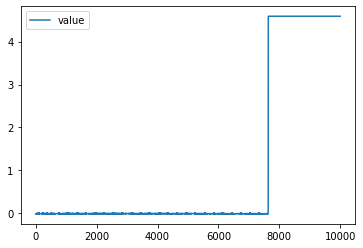

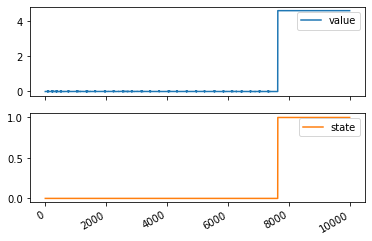

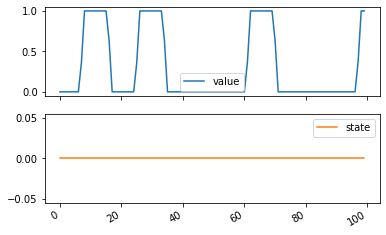

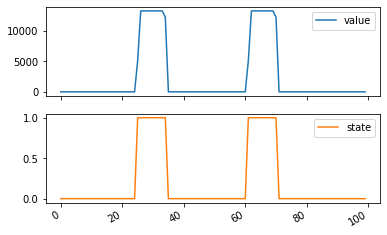

In [ ]:
import pandas as pd
import time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import scenedetect.frame_timecode as sce
import deeplabcut
import os


def main1():
  # DLC variables
  %matplotlib inline
  ProjectFolderName = 'Stage/sk_test-sanne-2021-09-08'
  VideoType = 'avi' 
  # video path 
  videofile_path = '/content/drive/My Drive/'+ProjectFolderName+'/videos/'
  videofile_path
  # config file
  path_config_file = '/content/drive/My Drive/'+ProjectFolderName+'/config.yaml'
  path_config_file

  # make file variables
  VIDEO_file = 'Full Videos/PointGreyVideo2020-05-04T10_34_08.avi'
  file_path = '/content/drive/My Drive/Stage/ADC_trial1/'
  ADC_file = '100_ADC1_0.continuous'
  LED_file = 'PointGreyLEDStatus2020-05-04T10_34_07.csv'



  # load in data as dataframes
  data = load(file_path+ADC_file)
  DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
  DF_p_led = pd.read_csv(file_path+LED_file, header=None)

  DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)
  DF_ADC_samples.iloc[0:10000].plot.line()
  DF_ADC_samples['state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(0,1), 'state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(1,5), 'state'] = 1
  DF_ADC_samples.iloc[0:10000].plot.line(subplots=True)
  group_size = 1000
  lst = [DF_ADC_samples.iloc[i:i+group_size] for i in range(0,len(DF_ADC_samples)-group_size+1,group_size)]

  bla = []
  for df in lst:
    m = df["state"].mean()
    bla.append(m)

  blabla = pd.DataFrame(bla)
  blabla.rename(columns={0: 'value'}, inplace=True)
  blabla['state'] = 0
  blabla.iloc[0:100].plot.line(subplots=True)
  blabla.loc[blabla['value'] <= 0, 'state'] = 0
  blabla.loc[blabla['value'] > 0, 'state'] = 1

  DF_p_led.rename(columns={0: 'value'}, inplace=True)
  DF_p_led['state'] = 0
  DF_p_led.loc[DF_p_led['value'] <= 500, 'state'] = 0
  DF_p_led.loc[DF_p_led['value'] > 500, 'state'] = 1
  DF_p_led.iloc[0:100].plot.line(subplots=True)

  trial = blabla.state.astype(str).str.cat()
  whole = DF_p_led['state'].astype(str).str.cat()

  
  #blabla.iloc[0:100].plot.line()
  #DF_p_led.iloc[0:100].plot.line()
  return whole, trial
whole,trial = main1()



  

In [ ]:
import pandas as pd
DF_p_led = pd.read_csv('/content/drive/My Drive/Stage/PointGreyLEDStatus2019-10-14T09_35_30.csv', header=None)
DF_p_frame = pd.read_csv('/content/drive/My Drive/Stage/PointGreyFramenumber2019-10-14T09_35_30.csv', header=None)
DF_p_time = pd.read_csv('/content/drive/My Drive/Stage/PointGreyTimestamps2019-10-14T09_35_30.csv', header=None)

print(len(DF_p_led))
print(len(DF_p_frame))
print(len(DF_p_time))

print(DF_p_frame.diff())

861229
861229
861229
          0
0       NaN
1       4.0
2       1.0
3       1.0
4       1.0
...     ...
861224  1.0
861225  1.0
861226  1.0
861227  1.0
861228  1.0

[861229 rows x 1 columns]


Loading continuous data...
91487
       whole  trial
0          0      0
1          0      0
2          0      0
3          0      0
4          0      0
...      ...    ...
99995      0      0
99996      0      0
99997      0      0
99998      0      0
99999      0      0

[100000 rows x 2 columns]


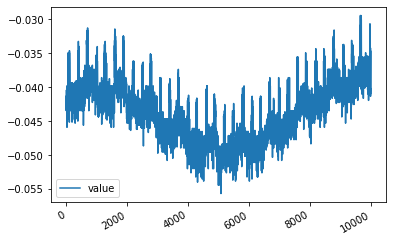

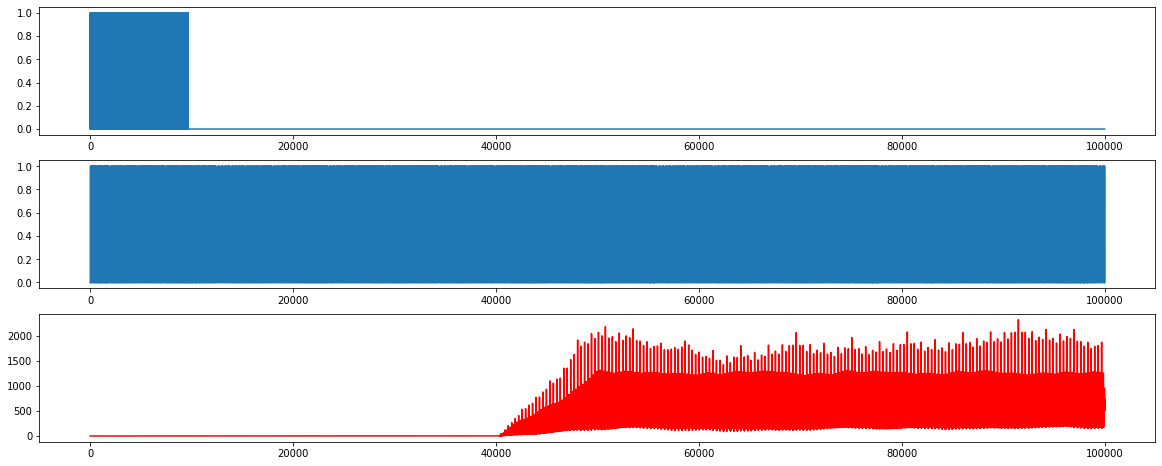

In [ ]:
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
whole_list =  list(map(int, list(whole)))[0:100000]
trial_list = list(map(int, list(trial)))[0:100000]

from itertools import repeat
trial_list = trial_list + list(repeat(0, len(whole_list)-len(trial_list)))

led_dict = {'whole': whole_list, 'trial':trial_list}
led_df = pd.DataFrame.from_dict(led_dict)

file_path = '/content/drive/My Drive/Stage/synch_test/'
ADC_file = 'Trial1/100_ADC1_0.continuous'
LED_file = 'PointGreyLEDStatus2018-07-30T11_24_12.csv'
TIME_file = 'PointGreyTimestamps2018-07-30T11_24_12.csv'
data = load(file_path+ADC_file)
DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)

DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)

DF_ADC_samples.iloc[0:10000].plot.line(subplots=True)
group_size = 1000
lst = [DF_ADC_samples.iloc[i:i+group_size] for i in range(0,len(DF_ADC_samples)-group_size+1,group_size)]

bla = []
for df in lst:
  m = df["value"].mean()
  bla.append(m)

import numpy as np
import matplotlib.pyplot as plct

#whole_list =  [1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,1,1,0,1,0,0]
#trial_list =  [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Fs=100
ts = np.arange(0,len(whole_list))

plt.figure(figsize=(20,8))
plt.subplot(3,1,1)
plt.plot(ts,trial_list)
plt.subplot(3,1,2)
plt.plot(ts,whole_list)


corr = np.correlate(whole_list, trial_list,'same')
#corr = np.correlate([1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,1,1,0,1,0,0],'same')

print(np.argmax(corr)) #this should be where correlation reaches its maximum value, and where the functions are most "similar"

plt.subplot(3,1,3)
plt.plot(corr, 'r')

print(led_df)

### Timestamp synch

Loading continuous data...
{'header': {'format': "'Open Ephys Data Format'", ' version': '0.4', ' header_bytes': '1024', 'description': "'each record contains one 64-bit timestamp, one 16-bit sample count (N), 1 uint16 recordingNumber, N 16-bit samples, and one 10-byte record marker (0 1 2 3 4 5 6 7 8 255)'", ' date_created': "'4-May-2020 112118'", 'channel': "'ADC1'", 'channelType': "'Continuous'", 'sampleRate': '30000', 'blockLength': '1024', 'bufferSize': '1024', 'bitVolts': '0.000152588'}, 'timestamps': array([2.048000e+03, 3.072000e+03, 4.096000e+03, ..., 9.678848e+06,
       9.679872e+06, 9.680896e+06]), 'data': array([-0.01113892, -0.00839234, -0.00869752, ...,  0.        ,
        0.        ,  0.        ]), 'recordingNumber': array([0., 0., 0., ..., 0., 0., 0.])}
              0
0        2048.0
1        3072.0
2        4096.0
3        5120.0
4        6144.0
...         ...
9448  9676800.0
9449  9677824.0
9450  9678848.0
9451  9679872.0
9452  9680896.0

[9453 rows x 1 columns]
 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a5f2428d0>,
      dtype=object)

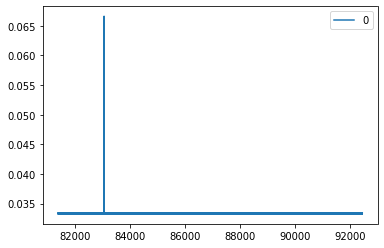

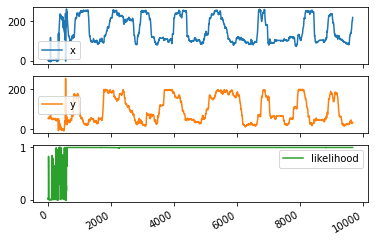

In [ ]:
import pandas as pd
import time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import scenedetect.frame_timecode as sce
import deeplabcut
import os


def main():
  # DLC variables
  %matplotlib inline
  ProjectFolderName = 'Stage/sk_test-sanne-2021-09-08'
  VideoType = 'avi' 
  # video path 
  videofile_path = '/content/drive/My Drive/'+ProjectFolderName+'/videos/'
  videofile_path
  # config file
  path_config_file = '/content/drive/My Drive/'+ProjectFolderName+'/config.yaml'
  path_config_file

  # make file variables
  file_path = '/content/drive/My Drive/Stage/ADC_trial1/'
  ADC_file = '100_ADC1_0.continuous'
  LED_file = 'PointGreyLEDStatus2020-05-04T10_34_07.csv'
  TIME_file = 'PointGreyTimestamps2020-05-04T10_34_07.csv'
  VIDEO_file = 'PointGreyVideo2018-07-30T11_24_12downsampled.avi'
  analysis_file = '/content/drive/My Drive/Stage/trail_1_whiteDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv'
  
  # load in data as dataframes
  data = load(file_path+ADC_file)
  print(data)
  DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
  DF_p_led = pd.read_csv(file_path+LED_file, header=None)
  DF_p_timestamps = pd.read_csv(file_path+TIME_file, header=None)
  DF_analysis = pd.read_csv(analysis_file, skiprows=2)

  # convert the pointgrey timestamps into seconds and uncylce them
  #DF_p_timestamps.iloc[0:10000].plot.line(subplots=True)
  DF_p_timestamps = convert_and_uncycle_timestamps(DF_p_timestamps)
  print(DF_ADC_timestamps)
  print(DF_p_timestamps)
  print(DF_p_timestamps.iloc[180074])
  DF_p_timestamps.iloc[81393:92455].diff().plot.line()
  #DF_p_timestamps.plot.line(subplots=True)
  # Divide all values by a thousand to make up for sampling rate of 30000
  t = DF_p_timestamps.diff()
  t_select = t.loc[t[0] > 0.033376]
  df = DF_p_timestamps[DF_p_timestamps.index.isin(t_select.index)]
  #t.plot.line()
  df_t = pd.to_datetime(df[0], unit='s').dt.strftime("%H:%M:%S.%f")
  print(df_t)
  df_t = df_t.to_frame()
  #df1 = DF_p_led[DF_p_led.index.isin(t_select.index)]

  df_tt = df_t[(df_t[0] < '01:37:37.927875')]
  df_ttt = t[t.index.isin(df_tt.index)]

  df_ttt = df_ttt.apply(lambda x: x - 0)
  a = df_ttt.sum()[0]
 
  # divide by 30k to convert to seconds
 # print(DF_ADC_timestamps)
  DF_ADC_timestamps = DF_ADC_timestamps.apply(dividething)
  print(DF_ADC_timestamps)
 # print(DF_ADC_timestamps)
 # print(DF_p_timestamps)
  # add pointgrey delay
  DF_p_ADC_timestamps1 = DF_ADC_timestamps.apply(lambda x: x - a) 
  DF_p_ADC_timestamps = DF_p_ADC_timestamps1.apply(lambda x: add_delay(x[0], DF_p_timestamps[0].iloc[0]),axis=1)
  #print(DF_p_ADC_timestamps[0])

  DF_time_1 = DF_p_ADC_timestamps.apply(lambda x: pd.to_datetime(x, unit='s').strftime('%H:%M:%S.%f'))

  DF_p_ADC_timestamps = DF_p_ADC_timestamps.apply(lambda x: x - DF_p_ADC_timestamps[0] ) 
  # Convert seconds into HH MM SS ff timestamps
  DF_time = DF_p_ADC_timestamps.apply(lambda x: pd.to_datetime(x, unit='s').strftime('%H:%M:%S.%f'))
  print(DF_time_1[0])
  print(DF_time_1.iloc[-1])

  #cut(video_file_path=file_path+VIDEO_file, start_time= DF_time_1[0], end_time=DF_time_1.iloc[-1])
  # convert the timestamps into frame numbers and put them in a list
  trial_frame_numbers = []

  for index, row in DF_time.items():
    x = sce.FrameTimecode(timecode = row, fps = 30.0)
    trial_frame_numbers.append(x.get_frames())

  DF_trial_ADC_framenumbers = pd.DataFrame (trial_frame_numbers, columns = ['frames'])
  #print(DF_trial_ADC_framenumbers)
  DF_subset = DF_analysis.loc[DF_analysis.index & DF_trial_ADC_framenumbers.frames]
  DF_head = DF_subset[['x','y','likelihood']]
  return DF_head
  """
  DF_ADC_timestamps = DF_ADC_timestamps.astype(int)


  # Find the first and last timestamp in the ADC file to later determine 
  # start and end time of the trial
  start = DF_ADC_timestamps[0].iloc[0]
  end = DF_ADC_timestamps[0].iloc[-1]
  start_time = int(DF_p_timestamps.loc[int(start),0])
  end_time = int(DF_p_timestamps.loc[int(end),0])

  timeframe = [str(start_time) + '-' + str(end_time)]
  print(timeframe)
  #cut_video(timeframe, file_path+VIDEO_file )
  # setup deeplabcut
  #os.environ["DLClight"]="True"
  # analyse new video
  #deeplabcut.analyze_videos(path_config_file, , save_as_csv=True)
  print(DF_p_timestamps)
  # Find the timestamps of the ADC file in the index of the pointgrey timestamps
  DF_p_ADC_timestamps = DF_p_timestamps.loc[DF_p_timestamps.index & DF_ADC_timestamps[0]]

  # Substract the starting time of the trial from the total seconds
  # so that you have the seconds of the actual trial video these times corrolate to
  DF_p_ADC_timestamps = DF_p_ADC_timestamps.apply(lambda x: transfer_frames(x[0], start_time),axis=1)

  # Convert seconds into HH MM SS ff timestamps
  DF_time = DF_p_ADC_timestamps.apply(lambda x: pd.to_datetime(x, unit='s').strftime('%H:%M:%S.%f'))
  # convert the timestamps into frame numbers and put them in a list
  trial_frame_numbers = []

  for index, row in DF_time.items():
    x = sce.FrameTimecode(timecode = row, fps = 30.0)
    trial_frame_numbers.append(x.get_frames())

  DF_trial_ADC_framenumbers = pd.DataFrame (trial_frame_numbers, columns = ['frames'])
  DF_subset = DF_analysis.loc[DF_analysis.index & DF_trial_ADC_framenumbers.frames]
  DF_head = DF_subset[['x','y','likelihood']]

  return DF_head
  """

head = main()
head.plot.line(subplots=True)

In [ ]:
cut(video_file_path='/content/drive/My Drive/Stage/white-TRIM.avi', start_time= '00:00:00.000000', end_time='00:05:43.722666')

Input #0, avi, from '/content/drive/My Drive/Stage/white-TRIM.avi':
  Metadata:
    encoder         : Lavf58.45.100
  Duration: 00:05:43.73, start: 0.000000, bitrate: 205 kb/s
    Stream #0:0: Video: mpeg4 (Simple Profile) (FMP4 / 0x34504D46), yuv420p, 325x256 [SAR 1:1 DAR 325:256], 199 kb/s, SAR 41984:41925 DAR 164:129, 30 fps, 30 tbr, 30 tbn, 30 tbc
Output #0, avi, to '/content/drive/My Drive/Stage//white-TRIM-TRIM.avi':
  Metadata:
    ISFT            : Lavf58.45.100
    Stream #0:0: Video: mpeg4 (Simple Profile) (FMP4 / 0x34504D46), yuv420p, 325x256 [SAR 41984:41925 DAR 164:129], q=2-31, 199 kb/s, 30 fps, 30 tbr, 30 tbn, 30 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (copy)
Press [q] to stop, [?] for help
frame=10301 fps=0.0 q=-1.0 Lsize=    8620kB time=00:05:43.73 bitrate= 205.4kbits/s speed=3.37e+03x    
video:8367kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.015925%


### Test branch

Loading continuous data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[  nan 1000.  999.    1.]


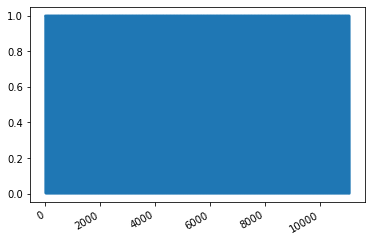

In [ ]:
import pandas as pd
import time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import scenedetect.frame_timecode as sce
import deeplabcut
import os
def load_all():
  # DLC variables
  ProjectFolderName = 'Stage/sk_test-sanne-2021-09-08'
  VideoType = 'avi' 
  # video path 
  videofile_path = '/content/drive/My Drive/'+ProjectFolderName+'/videos/'
  videofile_path
  # config file
  path_config_file = '/content/drive/My Drive/'+ProjectFolderName+'/config.yaml'
  path_config_file

  # make file variables
  file_path = '/content/drive/My Drive/Stage/synch_test/'
  ADC_file = 'Trial1/100_ADC2_0.continuous'
  LED_file = 'PointGreyLEDStatus2018-07-30T11_24_12.csv'
  TIME_file = 'PointGreyTimestamps2018-07-30T11_24_12.csv'
  VIDEO_file = 'PointGreyVideo2018-07-30T11_24_12downsampled.avi'
  analysis_file = '/content/drive/My Drive/Stage/trail_1_whiteDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv'
  
  # load in data as dataframes
  data = load(file_path+ADC_file)
  DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
  #DF_p_led = pd.read_csv(file_path+LED_file, header=None)
  DF_p_timestamps = pd.read_csv(file_path+TIME_file, header=None)
  #DF_analysis = pd.read_csv(analysis_file, skiprows=2)

  return DF_ADC_samples, DF_ADC_timestamps, DF_p_timestamps

def main5():
  # DLC variables
  %matplotlib inline
  DF_ADC_samples, DF_ADC_timestamps, DF_p_timestamps= load_all()
  df= DF_ADC_samples.diff()
  #df.iloc[0:5000].plot.line()
  #print(df.iloc[3580:35])
  df_s = df.loc[df[0] > 0.9]
  df_s['index1'] = df_s.index
  a = df_s['index1'].diff()
  print(a.unique())
  b = a.loc[a >= 999]
  
  b = b.reset_index()
  b['state'] = 0
  b.loc[b.index1 == 999, 'state'] = 0
  b.loc[b.index1 == 1000, 'state'] = 1
  b['state'].plot.line(subplots=True)

  #a.plot.line()

main5()

## DeepLabCut

In [ ]:
import os

all = []
for root, dirs, files in os.walk("/content/drive/My Drive/Stage/"):
    for file in files:
        if file.endswith(".avi"):
          if 'downsampled' in file:
            all.append(os.path.join(root, file))
          
for root, dirs, files in os.walk("/content/drive/My Drive/Stage/"):
    for file in files:
        if file.endswith(".avi"):
          old_file = os.path.join(root, file)
          already_in = False      
          if 'downsampled' not in file:
             file_z = file.replace('.', 'downsampled.')
             if os.path.join(root, file_z) in all:
                already_in = True
                #print(os.path.join(root, file))
             if already_in is False:
                old_file = os.path.join(root, file)
                file_l = file.split('.')
                file_l[1] = 'downsampled'
                file_l.append('.avi')
                file = ''.join(file_l)
                new_file =  os.path.join(root, file)
                !ffmpeg -i "$old_file" -filter:v scale=-1:256 -c:a copy "$new_file"
                os.remove(old_file)
             if already_in is True:
                os.remove(old_file)







### Variables

In [ ]:
import deeplabcut
#Setup your project variables:
# PLEASE EDIT THESE:
  
ProjectFolderName = 'Stage/final_tracker-Sanne-2021-10-20'
VideoType = 'avi' 

#don't edit these:
videofile_path = '/content/drive/My Drive/'+ProjectFolderName+'/videos/'
videofile_path
#Enter the list of videos or folder to analyze.

#This creates a path variable that links to your google drive copy
#No need to edit this, as you set it up before: 
path_config_file = '/content/drive/My Drive/'+ProjectFolderName+'/config.yaml'
path_config_file


#GUIs don't work on the cloud, so label your data locally on your computer! This will suppress the GUI support
import os
os.environ["DLClight"]="True"

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


### Version

In [ ]:
deeplabcut.__version__

### Training

In [ ]:
deeplabcut.create_training_dataset(path_config_file, net_type='resnet_50', augmenter_type='imgaug')

/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/training-datasets/iteration-0/UnaugmentedDataSet_final_trackerOct20  already exists!
/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/labeled-data/trail_4_bluedownsampled/CollectedData_Sanne.h5  not found (perhaps not annotated).
/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/labeled-data/trail_4_greendownsampled/CollectedData_Sanne.h5  not found (perhaps not annotated).
/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/labeled-data/trail_4_white(2)downsampled/CollectedData_Sanne.h5  not found (perhaps not annotated).
/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/labeled-data/trail_4_whitedownsampled/CollectedData_Sanne.h5  not found (perhaps not annotated).
/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/labeled-data/trail_5_greendownsampled/CollectedData_Sanne.h5  not found (perhaps not annotated).
/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/l

[(0.95,
  1,
  (array([153, 244,  13, 195,  32,  49,  74, 316, 189, 154, 114, 305, 107,
          267, 318, 295, 255,  50, 221,  83, 214, 339, 242, 171, 245, 187,
           34, 115, 302,  11, 313, 119, 231, 164, 218, 151, 317, 323, 156,
          262,  15, 182, 257, 307, 232,  40, 249,  17,  93, 178, 265,   1,
          141, 191, 236, 117,  86, 286, 104, 225, 294, 234,  92, 161, 241,
          300, 209, 174, 150, 113,  37, 293,  80, 126, 198, 299, 143, 148,
          135, 311, 190,  91, 110, 291, 181, 296, 258, 263, 341, 272, 152,
          288, 136,  47, 109,  20, 325, 227,  29, 335, 212,  65, 213, 192,
           39,  41, 310, 273,  70,  68,  95,  35, 336, 337, 252, 327,  98,
          256,  59, 144, 199, 229, 274, 146,  36, 196, 306, 169,  30, 179,
          173, 138, 132, 284,  94, 319,  48, 333,  16,  88, 125,  26, 103,
           72,  87,  25, 285, 277, 170, 131, 134, 158,  21, 120, 207, 157,
          282, 180,  46, 253, 290, 175, 276, 235,  19, 102, 108,  78, 210,
           6

In [ ]:
deeplabcut.train_network(path_config_file, displayiters=10,saveiters=15000)

Config:
{'all_joints': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]],
 'all_joints_names': ['Head',
                      'Sideleft',
                      'Sideright',
                      'Spine1',
                      'Tailbase',
                      'Tailmiddle',
                      'Tailend',
                      'CornerTopLeft',
                      'CornerBottomLeft',
                      'CornerTopRight',
                      'CornerBottomRight'],
 'alpha_r': 0.02,
 'apply_prob': 0.5,
 'batch_size': 1,
 'clahe': True,
 'claheratio': 0.1,
 'crop_pad': 0,
 'crop_sampling': 'hybrid',
 'crop_size': [400, 400],
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-0/UnaugmentedDataSet_final_trackerOct20/final_tracker_Sanne95shuffle1.mat',
 'dataset_type': 'imgaug',
 'decay_steps': 30000,
 'deterministic': False,
 'display_iters': 1000,
 'edge': False,
 'emboss': {'alpha': [0.0, 1.0], 'embossratio': 0.1, 'strength': [0.5, 1.5]},
 'fg_fraction': 0.25,
 'globa

Selecting single-animal trainer
Batch Size is 1
Loading ImageNet-pretrained resnet_50
Display_iters overwritten as 10
Save_iters overwritten as 1500
Training parameter:
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': '/content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/dlc-models/iteration-0/final_trackerOct20-trainset95shuffle1/train/snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refinement': True, 'locref_stdev': 7.2801, 'locref_loss_weight': 0.05, 'locref_huber_loss': True, 'optimizer': 'sgd', 'intermediate_supervision': False, 'intermediate_supervision_layer': 12, 'regularize': False, 'weight_decay': 0.0001, 'crop_pad': 0, 'scoremap_dir': 'test', 'batch_size': 1, 'dataset_type': 'imgaug', 'deterministic': False, 'mirror': False, 'pairwise_huber_loss': False, 'weigh_only_present_joints': False, 'partaffinityfield_predict': False, 'pairwi

Streaminguitvoer ingekort tot de laatste 5000 regels.
iteration: 261820 loss: 0.0031 lr: 0.02
iteration: 261830 loss: 0.0037 lr: 0.02
iteration: 261840 loss: 0.0042 lr: 0.02
iteration: 261850 loss: 0.0043 lr: 0.02
iteration: 261860 loss: 0.0037 lr: 0.02
iteration: 261870 loss: 0.0043 lr: 0.02
iteration: 261880 loss: 0.0040 lr: 0.02
iteration: 261890 loss: 0.0040 lr: 0.02
iteration: 261900 loss: 0.0033 lr: 0.02
iteration: 261910 loss: 0.0043 lr: 0.02
iteration: 261920 loss: 0.0050 lr: 0.02
iteration: 261930 loss: 0.0044 lr: 0.02
iteration: 261940 loss: 0.0049 lr: 0.02
iteration: 261950 loss: 0.0035 lr: 0.02
iteration: 261960 loss: 0.0035 lr: 0.02
iteration: 261970 loss: 0.0036 lr: 0.02
iteration: 261980 loss: 0.0031 lr: 0.02
iteration: 261990 loss: 0.0035 lr: 0.02
iteration: 262000 loss: 0.0028 lr: 0.02
iteration: 262010 loss: 0.0030 lr: 0.02
iteration: 262020 loss: 0.0033 lr: 0.02
iteration: 262030 loss: 0.0030 lr: 0.02
iteration: 262040 loss: 0.0033 lr: 0.02
iteration: 262050 loss: 0.

### Evaluation

In [ ]:
%matplotlib notebook
deeplabcut.evaluate_network(path_config_file,plotting=True)

Running  DLC_resnet50_final_trackerOct20shuffle1_312000  with # of trainingiterations: 312000
Analyzing data...


345it [06:34,  1.14s/it]

Done and results stored for snapshot:  snapshot-312000
Results for 312000  training iterations: 95 1 train error: 3.44 pixels. Test error: 5.48  pixels.
With pcutoff of 0.6  train error: 2.75 pixels. Test error: 4.74 pixels
Thereby, the errors are given by the average distances between the labels by DLC and the scorer.
Plotting...


<IPython.core.display.Javascript object>

100%|██████████| 345/345 [00:58<00:00,  5.89it/s]

The network is evaluated and the results are stored in the subdirectory 'evaluation_results'.
If it generalizes well, choose the best model for prediction and update the config file with the appropriate index for the 'snapshotindex'.
Use the function 'analyze_video' to make predictions on new videos.
Otherwise consider retraining the network (see DeepLabCut workflow Fig 2)


In [ ]:
#deeplabcut.extract_save_all_maps(path_config_file, shuffle=1, Indices=[0, 5])

### Analysis


In [ ]:
videofile_path = '/content/drive/My Drive/Stage/white_TRIM.avi'
deeplabcut.analyze_videos(path_config_file, [videofile_path], save_as_csv=True)


In [ ]:
deeplabcut.plot_trajectories(path_config_file, videofile_path)

In [ ]:
deeplabcut.create_labeled_video(path_config_file,videofile_path, videotype='.avi', draw_skeleton = True)

In [ ]:
deeplabcut.analyze_videos_converth5_to_csv('/content/drive/My Drive/Stage/Noise_check/2019/',videotype=VideoType)

Found output file for scorer: DLC_resnet50_downsampled_trackerSep16shuffle1_180000
Converting /content/drive/My Drive/Stage/Noise_check/2019/rat_training_OS_N_S_SD_CI_1_t0001downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.h5...
Found output file for scorer: DLC_resnet50_downsampled_trackerSep16shuffle1_180000
Converting /content/drive/My Drive/Stage/Noise_check/2019/rat_training_OS_N_S_SD_CI_1_t0002downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.h5...
Found output file for scorer: DLC_resnet50_downsampled_trackerSep16shuffle1_180000
Converting /content/drive/My Drive/Stage/Noise_check/2019/rat_training_OS_N_S_SD_CI_1_t0003downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.h5...
Found output file for scorer: DLC_resnet50_downsampled_trackerSep16shuffle1_180000
Converting /content/drive/My Drive/Stage/Noise_check/2019/rat_training_OS_N_S_SD_CI_1_t0004downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.h5...
Found output file for sc

### Pipeline

In [ ]:
 import os
 basepath = '/content/drive/My Drive/Stage/Downsampled'

tracker_name = 'DLC_resnet50_downsampled_trackerSep16shuffle1_180000'
all_files = []
for root, dirs, files in os.walk(basepath):
    for file in files:
        if file.endswith('.avi'):
            file = file.strip('.avi')
            file = file+tracker_name+'.csv'
            all_files.append(file)
            print(file)


trail_1_whitedownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_1_bluedownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_1_greendownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_1_reddownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_1_white(2)downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_2_bluedownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_2_greendownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_2_reddownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_2_white(2)downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_2_whitedownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_3_bluedownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_3_greendownsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
trail_3_whitedownsampledDLC_r

In [ ]:
import os
import deeplabcut

def get_analysis_files(directory, tracker_name):
  #tracker_name = 'DLC_resnet50_downsampled_trackerSep16shuffle1_180000'
  all_analysis_files = []
  all_skeleton_files = []
  for root, dirs, files in os.walk(directory):
      for file in files:
          if file.endswith('.avi'):
              file = file.strip('.avi')
              file_a = file+tracker_name+'.csv'
              file_s = file+tracker_name+'_skeleton.csv'
              all_analysis_files.append(file_a)
              all_skeleton_files.append(file_s)
  
def main_deeplabcut(directory, config, videoType, save_csv, create_labeled, create_plots, analyze_skeleton):
  # analyse
  deeplabcut.analyze_videos(config, [directory], save_as_csv=save_csv)
  if create_plots:
    # plot trajectory
    deeplabcut.plot_trajectories(config, [directory])
  if create_labeled:
    deeplabcut.create_labeled_video(config, [directory], videotype=videoType, draw_skeleton = True)
  if analyze_skeleton:
    deeplabcut.analyzeskeleton(config, [directory], videotype=videoType, shuffle=1, trainingsetindex=0, save_as_csv=True, destfolder=None)


ProjectFolderName = 'Stage/final_tracker-Sanne-2021-10-20'
VideoType = 'avi' 
path_config_file = '/content/drive/My Drive/'+ProjectFolderName+'/config.yaml'

main_deeplabcut('/content/drive/My Drive/Stage/Noise_check/2020/',path_config_file,VideoType,True,True,True,True)
main_deeplabcut('/content/drive/My Drive/Stage/Noise_check/2017/',path_config_file,VideoType,save_csv=False,create_labeled=False,create_plots=True,analyze_skeleton=False)
main_deeplabcut('/content/drive/My Drive/Stage/Noise_check/2018/',path_config_file,VideoType,save_csv=False,create_labeled=False,create_plots=True,analyze_skeleton=False)
main_deeplabcut('/content/drive/My Drive/Stage/Noise_check/2019/',path_config_file,VideoType,save_csv=False,create_labeled=False,create_plots=True,analyze_skeleton=False)
main_deeplabcut('/content/drive/My Drive/Stage/Trials/Downsampled/',path_config_file,VideoType,save_csv=False,create_labeled=False,create_plots=True,analyze_skeleton=False)

Using snapshot-312000 for model /content/drive/My Drive/Stage/final_tracker-Sanne-2021-10-20/dlc-models/iteration-0/final_trackerOct20-trainset95shuffle1
Analyzing all the videos in the directory...
Starting to analyze %  /content/drive/My Drive/Stage/Noise_check/2020/rat_training_OS_N_S_SD_CI_1_t0004_raw_2020downsampled.avi
/content/drive/My Drive/Stage/Noise_check/2020  already exists!
Loading  /content/drive/My Drive/Stage/Noise_check/2020/rat_training_OS_N_S_SD_CI_1_t0004_raw_2020downsampled.avi
Duration of video [s]:  336.37 , recorded with  30.0 fps!
Overall # of frames:  10091  found with (before cropping) frame dimensions:  341 256
Starting to extract posture


  3%|▎         | 300/10091 [01:16<44:24,  3.67it/s]

## Automatic assesment of tracker

- ### tracking an object:
	##### signs:
	- Huge jump
	- Constant coordinates for a long period of time
	- likelihood can be high in this case (sometimes its just super certain its a rat while its not)
- ### Uncertain tracking:
	##### signs:
	- Likelihood around 20-80%
	- Tracking graph might seem reasonable but is probably tracking wrong parts
		- Should manually assess the video to be certain
	- Large gaps when applying pc-cutOff (basically everything below 0,6 is not taken into account when plotting the trajectory or making a video)


### What do I want to achieve:

	- Average likelihood of all bodyparts seperatly
	- Average likelihood of everything combined
	- List of videos that performed poorly
	- Reason as to why they performed poorly
		- Tracking an object (object not used before has similar features)
		- Uncertain tracking (new situation not trained on before)


### Scoring the performance

things to consider in score:


*   Head and spine most important
*   Tail parts least important
*   Outliers can mean lots of false positives
*   High likelihood is good if most is high and the rest very low if there is more in between than low, the model is uncertain


### likelihood system:
I give each video a score based on their likelihoods by calculating how much of their values are above 80%, between 80% and 20% and below 20%. If most is above 80% it is good but there might still be uncertainty. If most if above 80% and the more is below 20% than in the between area it means there is less uncertainty and it is good. If the likelihood is not on average above 80% it means it is simply uncertain

these percentages should change

*   1 = high likelihood and not much uncertainty
*   2 = high likelihood but with some uncertainty
*   3 = low likelihood with much uncertainty





In [ ]:
import pandas as pd

import os


def main3():
  file_path = '/content/drive/My Drive/Stage/Noise_check/2017/'
  #analysis_file = 'rat_training_OS_SERT_5d_t0013downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv'
  
  
  all_files = []
  for root, dirs, files in os.walk(file_path):
      for file in files:
          if file.endswith('.csv'):
              if 'skeleton' not in file:
                all_files.append(file)
                print(file)
  parts_dic = {'x' : 'Head', 'x.1' : 'Side left', 'x.2' : 'Side right', 'x.3' : 'Spine', 'x.4' : 'Tail base', 'x.5': 'Tail middle', 'x.6': 'Tail end'}
  parts = ['x', 'x.1', 'x.2', 'x.3', 'x.4', 'x.5', 'x.6']
  result_dic = {}

  
  for analysis_file in all_files:
    DF_analysis = pd.read_csv(file_path+analysis_file, skiprows=2)
    t = DF_analysis.diff()
  #  print('Outlier/Jump analysis')
    full_o = []
    for value in parts:
      # if the outlier value is above like 0.1% of everyting its already too much
      # outlier value should be below 0.09% Basically as little as possible bc jumps of 100 pixels should not occur
      outliers =t.loc[t[value]> 100]
      #print(parts_dic[value])
      #print(str(len(outliers)/len(DF_analysis)*100) + ' %')
      full_o.append(len(outliers)/len(DF_analysis)*100)
    print(sum(full_o)/len(full_o))
    if sum(full_o)/len(full_o) < 0.5:
      print('false')
      result_dic[analysis_file] = {'outlier' : False}
    else:
      print('true')
      result_dic[analysis_file] = {'outlier' : True}
    result_dic[analysis_file]['outlier_results'] = full_o

    #print()
    #print('likelihood analysis')
    full_l = []
    full_c = []
    full_low = []
    for part in parts:
      likelihood = part.replace('x', 'likelihood')
      # if a and b are low and c is high it is good
      # if b and a are high en c is low it is very bad
      # if b is low and b is average and c is high it is good
      ## Find out what high, low and average values are
      uncertain = DF_analysis.loc[DF_analysis[likelihood].between(0.1,0.9)]
      low = DF_analysis.loc[DF_analysis[likelihood] < 0.1]
      high = DF_analysis.loc[DF_analysis[likelihood] > 0.9]
      full_l.append(len(high)/len(DF_analysis)*100)
      full_c.append(len(uncertain)/len(DF_analysis)*100)
      full_low.append(len(low)/len(DF_analysis)*100)
      #print(parts_dic[part])
      #print(len(uncertain)/len(DF_analysis)*100)
      #print(len(low)/len(DF_analysis)*100)
      #print(len(high)/len(DF_analysis)*100)
    if sum(full_l)/len(full_l) >= 80.0 and sum(full_low)/len(full_low) > sum(full_c)/len(full_c):
      result_dic[analysis_file]['likelihood'] = 1
    elif sum(full_l)/len(full_l) >= 80.0:
      result_dic[analysis_file]['likelihood'] = 2
    else:
      result_dic[analysis_file]['likelihood'] = 3
    result_dic[analysis_file]['likelihood_results'] = full_l
    max_l = 'x.' + str(result_dic[analysis_file]['likelihood_results'].
                      index(max(result_dic[analysis_file]['likelihood_results']))
                      )
    min_l = 'x.' + str(result_dic[analysis_file]['likelihood_results'].
                      index(min(result_dic[analysis_file]['likelihood_results']))
                      )
    max_o = 'x.' + str(result_dic[analysis_file]['outlier_results'].
                      index(max(result_dic[analysis_file]['outlier_results']))
                      )
    min_o = 'x.' + str(result_dic[analysis_file]['outlier_results'].
                      index(min(result_dic[analysis_file]['outlier_results']))
                      )
  return result_dic
  




d = main3()

rat_training_OS_SERT_5d_t0001downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0002downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0003downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0004downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0005downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0006downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0007downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0008downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0009downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0010downsampledDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv
rat_training_OS_SERT_5d_t0011d

In [ ]:
d_2 = pd.DataFrame.from_dict(d, orient='index')
videos_for_manual_inspection = d_2[(d_2['likelihood'].between(2,3)) & (d_2['outlier']==True)]
print(videos_for_manual_inspection)
d_2.to_csv('assess_2.csv')

                                                    outlier  ...                                 likelihood_results
rat_training_OS_SERT_5d_t0001downsampledDLC_res...     True  ...  [20.995493650143384, 55.36665301106104, 75.747...
rat_training_OS_SERT_5d_t0002downsampledDLC_res...     True  ...  [16.784378894889905, 59.45159950145409, 58.558...
rat_training_OS_SERT_5d_t0003downsampledDLC_res...     True  ...  [18.472395184723954, 27.41801577418016, 39.684...
rat_training_OS_SERT_5d_t0004downsampledDLC_res...     True  ...  [13.509605453418716, 43.069613716174345, 44.24...
rat_training_OS_SERT_5d_t0005downsampledDLC_res...     True  ...  [9.963325183374083, 20.925020374898125, 26.792...
rat_training_OS_SERT_5d_t0006downsampledDLC_res...     True  ...  [7.07196029776675, 38.13068651778329, 43.36228...
rat_training_OS_SERT_5d_t0007downsampledDLC_res...     True  ...  [18.830628381190177, 19.662921348314608, 30.02...
rat_training_OS_SERT_5d_t0008downsampledDLC_res...     True  ...  [24.65